# Deep Learning

In this notebook, we move from single layer to networks with at least 2 layers. With this the numebr of neurons drammattically increases. Building on previous tutorial, we will program our own class to handle any number of layers. We will first train a very simple 2 layer network to solve the XOR problem and verify that we can target non linearly separable data sets. We then will train a larger 2 hidden layer network to solve the MNIST data set with an accuracy of more that 90%.

Run the notebook in Google colab:
https://colab.research.google.com/github/heprom/cvml/blob/main/corrections/deep_learning_cor.ipynb

## Quick Implementation of a two layer NN

Two layers with two inputs: $w^{(1)}$ has size (3, 3) including the bias and $w^{(2)}$ has size (3, 1) to give one output.

In [10]:
import numpy as np
from matplotlib import pyplot as plt, cm

X = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])  # include term for the bias trick
y = np.array([[0], [1], [1], [0]])
#print(X)
#print(y)

np.random.seed(2)
w1 = np.random.randn(3, 3)  # first layer
w2 = np.random.randn(3, 1)  # second layer
print('* model params: {}'.format(w2.tolist()))
eta = 1e-1  # learning rate
n_epochs = 1000

for t in range(n_epochs):
    # forward pass
    h = 1 / (1 + np.exp(-X.dot(w1)))  # activation of the first layer
    y_pred = h.dot(w2)  # activation of the second layer
    loss = np.square(y_pred - y).sum()
    print(t, loss)

    # backprop
    grad_y_pred = 2. * (y_pred - y)
    grad_w2 = h.T.dot(grad_y_pred)
    print(grad_w2)
    grad_h = grad_y_pred.dot(w2.T)
    grad_w1 = X.T.dot(grad_h * h * (1 - h))

    # update rule
    w1 -= eta * grad_w1
    w2 -= eta * grad_w2
print('* new model params: {}'.format(w2.tolist()))

* model params: [[-0.9090076149268493], [0.5514540445464243], [2.2922080128149576]]
0 4.425280442161884
[[-4.74748827]
 [-0.87028426]
 [-0.2397189 ]]
1 2.4009755996430897
[[-2.6968341 ]
 [-0.36937819]
 [-0.11822431]]
2 1.7514776779341479
[[-1.72656014]
 [-0.10442793]
 [-0.04987983]]
3 1.4851663710456895
[[-1.15822711]
 [ 0.0567642 ]
 [-0.00689677]]
4 1.3613460738774013
[[-0.79746006]
 [ 0.15663534]
 [ 0.02029713]]
5 1.296774593148296
[[-0.56185941]
 [ 0.21654372]
 [ 0.03690372]]
6 1.2582016240307001
[[-0.40643527]
 [ 0.25000982]
 [ 0.04641389]]
7 1.2316548961122393
[[-0.30327377]
 [ 0.26621375]
 [ 0.05127507]]
8 1.2111506750799732
[[-0.23424732]
 [ 0.27139332]
 [ 0.05317358]]
9 1.1940752612095897
[[-0.18747881]
 [ 0.26971073]
 [ 0.05323834]]
10 1.1792393702753092
[[-0.15521058]
 [ 0.26389003]
 [ 0.0522059 ]]
11 1.1660583465210212
[[-0.13240193]
 [ 0.25568499]
 [ 0.05054708]]
12 1.154208724644271
[[-0.11579101]
 [ 0.2462092 ]
 [ 0.04855771]]
13 1.1434846578104292
[[-0.1032718 ]
 [ 0.236

print the results of the predictions with our trained model

In [24]:
for (xi, yi) in zip(X, y):
    h = 1 / (1 + np.exp(-xi.dot(w1)))
    out = np.dot(h, w2)
    y_pred = 1 if out > 0.5 else 0
    print('data={}, ground-truth={}, out={:.3f}, y={}'.format(xi, yi, out[0], y_pred))


data=[1 0 0], ground-truth=[0], out=0.001, y=0
data=[1 0 1], ground-truth=[1], out=0.999, y=1
data=[1 1 0], ground-truth=[1], out=0.999, y=1
data=[1 1 1], ground-truth=[0], out=0.002, y=0


## General Implementation

We modify our previous implementation of a Neural Network to include any number of layers. Additionnally, each layer can have any number of neurons.

In [30]:
x = np.array([4, 5, 6])
print(x)
print(np.atleast_2d(x))
np.atleast_2d(x).shape

[4 5 6]
[[4 5 6]]


(1, 3)

In [58]:
class NeuralNetwork:
    """Artificial Neural Network class. 
    
    A general Feed-Forward Neural Network. Here, the activation function is a sigmoid, 
    the loss is computed using the squared error between the target and 
    the prediction. Learning the parameters is achieved using back-propagation 
    and gradient descent
    """
    
    def __init__(self, layers, eta=0.1, rand_seed=42):
        """Initialisation routine."""
        np.random.seed(rand_seed)
        self.W = []
        self.layers = layers  # keep a record of this
        # loop on the layers except for the last one
        for i in np.arange(0, len(layers) - 2):
            w = np.random.randn(layers[i] + 1, layers[i+1] + 1)
            self.W.append(w)
        # the last layer does not need a bias for its output
        w = np.random.randn(layers[-2] + 1, layers[-1])
        self.W.append(w)
        self.eta = eta  # learning rate
        self.loss_history = []
    
    def __repr__(self):
        """Simple string representation of the network."""
        return "NeuralNetwork: {}".format('-'.join(str(l) for l in self.layers))

    def sigmoid(self, x):
        """Our activation function."""
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_grad(self, x):
        """Gradient of the sigmoid function."""
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def predict(self, X, bias_trick=True):
        """Compute the output of the network for the input X. 
        Notice that out value of bounded between 0 and 1."""
        p = np.atleast_2d(X)
        if bias_trick:
            # bias trick
            p = np.c_[np.ones((p.shape[0])), p]
        for layer in np.arange(0, len(self.layers) - 1):
            p = self.sigmoid(np.dot(p, self.W[layer]))
        return p
    
    def loss(self, X, y, bias_trick=False):
        """Compute the squared error loss for a given set of inputs."""
        y = np.atleast_2d(y)
        y_pred = self.predict(X, bias_trick=bias_trick)
        loss = np.sum((y_pred - y) ** 2)
        return loss
        
    def back_propagation(self, X, y):
        """Conduct backpropagation to update the weights."""
        # we need to keep a list of the activation of each layer
        A = [np.atleast_2d(X)]
        
        # forward pass
        for layer in np.arange(0, len(self.layers) - 1):
            a = A[layer].dot(self.W[layer])
            #print(layer, a)
            A.append(self.sigmoid(a))

        # backprop phase
        D = [(A[-1] - y) * A[-1] * (1 - A[-1])]
        for layer in np.arange(len(A) - 2, 0, -1):
            #print(layer)
            delta = D[-1].dot(self.W[layer].T)
            delta = delta * A[layer] * (1 - A[layer])
            D.append(delta)
        D = D[::-1]  # reverse the order
        
        # update weights
        for layer in np.arange(0, len(self.layers) - 1):
            grad_W = 2 * A[layer].T.dot(D[layer])
            self.W[layer] -= self.eta * grad_W

    def fit(self, X, y, n_epochs=10, method='batch', display_update=100):
        """Perform gradient descent on a given number of epochs to update the weights."""
        # bias trick: add a column of 1 to X
        X = np.c_[np.ones((X.shape[0])), X]
        for i_epoch in range(n_epochs):
            if method == 'batch':
                # perform backprop on the whole training set (batch)
                self.back_propagation(X, y)
            else:
                # here we update the weight for every data point (SGD)
                for (xi, yi) in zip(X, y):
                    self.back_propagation(xi, yi)
            # an epoch has passed, compute the loss
            loss = self.loss(X, y)
            self.loss_history.append(loss)
            if i_epoch == 0 or (1 + i_epoch) % display_update == 0:
                print("epoch={}, loss={:.3f}".format(1 + i_epoch, loss))


## XOR problem

In [64]:
# define our 2-2-1 neural network and train it
np.random.seed(42)
nn = NeuralNetwork(layers=[2, 2, 1], eta=0.5)

In [65]:
# test our __repr__function
print(nn)

NeuralNetwork: 2-2-1


In [66]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])
print('W shape: {}'.format([Wi.shape for Wi in nn.W]))
print('initial weights:', nn.W)
nn.fit(X, y, n_epochs=1000, method='SGD', display_update=50)

W shape: [(3, 3), (3, 1)]
initial weights: [array([[ 0.49671415, -0.1382643 ,  0.64768854],
       [ 1.52302986, -0.23415337, -0.23413696],
       [ 1.57921282,  0.76743473, -0.46947439]]), array([[ 0.54256004],
       [-0.46341769],
       [-0.46572975]])]
epoch=1, loss=0.977
epoch=50, loss=0.950
epoch=100, loss=0.891
epoch=150, loss=0.773
epoch=200, loss=0.603
epoch=250, loss=0.370
epoch=300, loss=0.181
epoch=350, loss=0.097
epoch=400, loss=0.061
epoch=450, loss=0.043
epoch=500, loss=0.033
epoch=550, loss=0.026
epoch=600, loss=0.021
epoch=650, loss=0.018
epoch=700, loss=0.016
epoch=750, loss=0.014
epoch=800, loss=0.012
epoch=850, loss=0.011
epoch=900, loss=0.010
epoch=950, loss=0.009
epoch=1000, loss=0.008


In [62]:
for (xi, yi) in zip(X, y):
    out = nn.predict(xi)
    y_pred = 1 if out > 0.5 else 0
    print('data={}, ground-truth={}, out={:.3f}, y={}'.format(xi, yi, out[0][0], y_pred))


data=[0 0], ground-truth=[0], out=0.043, y=0
data=[0 1], ground-truth=[1], out=0.970, y=1
data=[1 0], ground-truth=[1], out=0.943, y=1
data=[1 1], ground-truth=[0], out=0.050, y=0


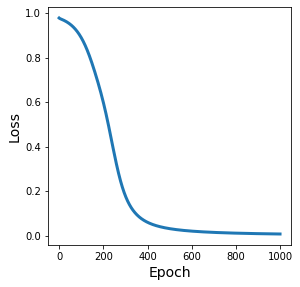

In [68]:
plt.figure(figsize=(4.5, 4))
plt.plot(nn.loss_history, linewidth=3)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.subplots_adjust(left=0.15, top=0.95)
plt.show()

## Solving the MNIST data set

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

In [6]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [7]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [11]:
print(digits['images'].shape)
print(digits['images'].dtype)
print(digits['images'].min())
print(digits['images'].max())
print(digits['data'].shape)
print(digits['data'].dtype)

index = 34
print(digits['data'][index, :].reshape((8, 8)))
np.sum(digits['data'][index, :] == digits['images'][index].ravel())

(1797, 8, 8)
float64
0.0
16.0
(1797, 64)
float64
[[ 0.  0.  0.  5. 14.  2.  0.  0.]
 [ 0.  0.  1. 13. 11.  0.  0.  0.]
 [ 0.  0.  5. 16.  2.  0.  0.  0.]
 [ 0.  0.  6. 15.  5.  0.  0.  0.]
 [ 0.  1. 15. 16. 15. 11.  1.  0.]
 [ 0.  2. 13. 14.  1. 12.  9.  0.]
 [ 0.  0.  4. 16.  7. 13.  9.  0.]
 [ 0.  0.  0.  5. 16. 15.  3.  0.]]


64

plot the image with index `index`

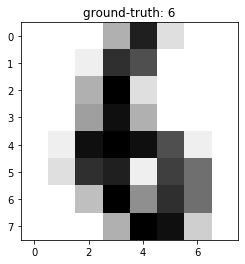

In [12]:
plt.imshow(digits['images'][index], cmap=cm.gray_r)
plt.title('ground-truth: %d' % digits.target[index])
plt.show()

have a look at the first few images

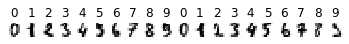

In [13]:
n_images = 20
fig, axes = plt.subplots(1, n_images)
for i in range(n_images):
    ax = axes[i]
    ax.set_axis_off()
    ax.imshow(digits['images'][i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('%i' % digits['target'][i])

In [14]:
# split the data into a training and a testing set
(X_train, X_test, y_train, y_test) = train_test_split(digits['data'] / 16.0, digits['target'], test_size=0.25, random_state=13)
print(X_train.shape)
print('first 10 train labels: {}'.format(y_train[:10]))
print('first 10 test labels: {}'.format(y_test[:10]))

(1347, 64)
first 10 train labels: [0 7 1 3 7 8 9 2 3 6]
first 10 test labels: [9 1 1 3 1 3 4 9 5 8]


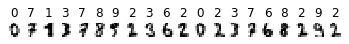

In [15]:
# verify training images
fig, axes = plt.subplots(1, n_images)
for i in range(n_images):
    ax = axes[i]
    ax.set_axis_off()
    ax.imshow(X_train[i].reshape((8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('%i' % y_train[i])

With our network implementation, the output of the network is bounded between 0 and 1 (output of the sigmoidal function). We could have implemented a multinomial SVM classifier but instead we will use autoencoders to keep it very general.

Each digit is transformed into a 10 component vector of zero axecpt for a 1 at the position of the digit. For example 6 become [0, 0, 0, 0, 0, 1, 0, 0, 0]. This allows to create a 10 output network and to compare each output with the transformed version of each label.

We use `scikit-learn` utility `LabelBinarizer` for this.

In [16]:
from sklearn.preprocessing import LabelBinarizer

# convert the labels from integers to vectors
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
print(y_train.shape)
for i in range(10):
    print('{}: {}'.format(y_train[i].argmax(), y_train[i]))

(1347, 10)
0: [1 0 0 0 0 0 0 0 0 0]
7: [0 0 0 0 0 0 0 1 0 0]
1: [0 1 0 0 0 0 0 0 0 0]
3: [0 0 0 1 0 0 0 0 0 0]
7: [0 0 0 0 0 0 0 1 0 0]
8: [0 0 0 0 0 0 0 0 1 0]
9: [0 0 0 0 0 0 0 0 0 1]
2: [0 0 1 0 0 0 0 0 0 0]
3: [0 0 0 1 0 0 0 0 0 0]
6: [0 0 0 0 0 0 1 0 0 0]


create our neural network with 4 layers of 64, 32, 16 and finally 10 neurons.

In [80]:
np.random.seed(42)
nn = NeuralNetwork([64, 32, 16, 10])
print(nn)
print("learning rate {}".format(nn.eta))

nn.fit(X_train, y_train, n_epochs=100, method='SGD', display_update=10)

NeuralNetwork: 64-32-16-10
learning rate 0.1
epoch=1, loss=1078.892
epoch=10, loss=123.737
epoch=20, loss=51.494
epoch=30, loss=23.882
epoch=40, loss=15.070
epoch=50, loss=10.914
epoch=60, loss=8.788
epoch=70, loss=7.631
epoch=80, loss=6.900
epoch=90, loss=6.382
epoch=100, loss=5.792


Plot the loss saved during training

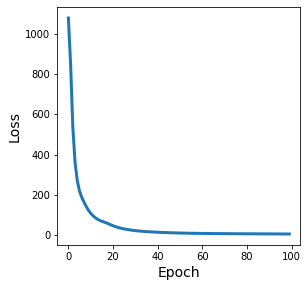

In [81]:
plt.figure(figsize=(4.5, 4))
plt.plot(nn.loss_history, linewidth=3)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.subplots_adjust(left=0.15, top=0.95)
plt.show()

In [86]:
# have a look at a particular data point from the test set
index = 12
y_pred = nn.predict(X_test[index, :])
print(y_pred)
y_class = y_pred.argmax()
y = y_test[index].argmax()
print('test image {}: predict a {} - ground truth is a {}'.format(index, y_class, y))

[[5.55756497e-04 6.49810944e-03 9.96592780e-01 1.18272559e-02
  2.76571247e-05 3.96715622e-03 3.82660275e-04 9.96949722e-04
  3.56266391e-03 4.54447835e-07]]
test image 12: predict a 2 - ground truth is a 2


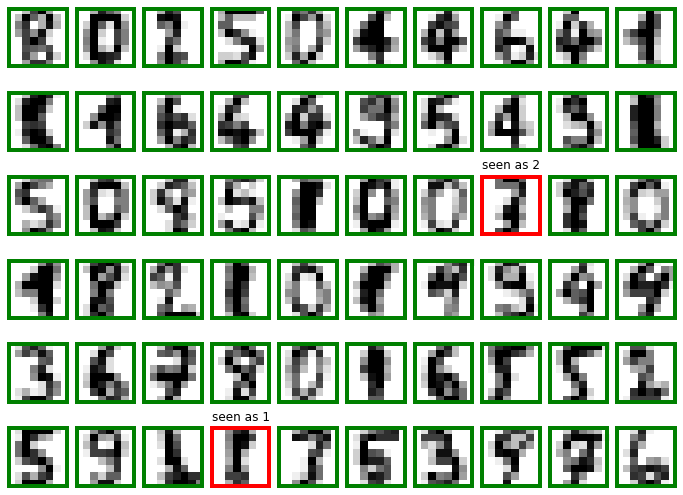

In [88]:
import matplotlib.patches as patches

start_index = 10
plt.figure(figsize=(12, 9))
for i, index in enumerate(range(start_index, start_index + 60)):
    y_pred = nn.predict(X_test[index, :])
    y_class = np.argmax(y_pred)
    y = np.argmax(y_test[index])
    ax = plt.subplot(6, 10, i + 1)
    ax.imshow(X_test[index, :].reshape((8, 8)), cmap=cm.gray_r)
    if y_class == y:
        color = 'green'
    else:
        color = 'red'
        plt.title('seen as {}'.format(y_class))
    rect = patches.Rectangle((-0.5, -0.5), 8.0, 8.0, linewidth=8, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
plt.subplots_adjust(wspace=0.1)
plt.show()

In [89]:
from sklearn.metrics import classification_report

predictions = nn.predict(X_test)
y_test_pred = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.91      0.95      0.93        44
           2       0.96      0.98      0.97        45
           3       0.96      0.92      0.94        51
           4       0.96      1.00      0.98        47
           5       0.98      0.93      0.95        56
           6       1.00      0.98      0.99        49
           7       1.00      1.00      1.00        36
           8       0.93      0.93      0.93        45
           9       0.95      0.98      0.97        43

    accuracy                           0.96       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.96      0.96      0.96       450



In [93]:
from sklearn.metrics import confusion_matrix
predictions = nn.predict(X_train)
print(predictions.shape)
y_train_pred = predictions.argmax(axis=1)
conf = confusion_matrix(y_train.argmax(axis=1), y_train_pred)

(1347, 10)


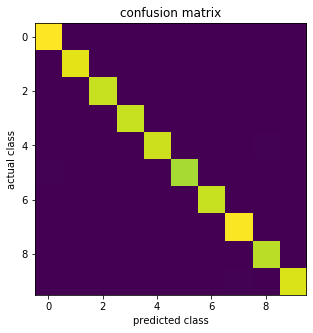

In [91]:
plt.figure(figsize=(5, 5))
plt.imshow(conf)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('confusion matrix')
plt.savefig('mnist_deep_learning_confusion_matrix.pdf')
plt.show()

## Using Keras

Keras is a high level programming interface to build deep Neural Networks. It need a backend to run (to actually build te computational graph, compute the gradients and so on).

Note that starting from version 2.3.0, Keras is now part of TensorFlow (which is now the default and only backend).

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

### Using Sigmoid layers

In [2]:
# define the 94-32-16-10 architecture using Keras
model = Sequential()
model.add(Dense(32, input_shape=(64,), activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [3]:
sgd = SGD(0.01)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=sgd, 
    metrics=['accuracy'])

Train the model on 300 epochs

In [17]:
print('training network...')
H = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=300, 
    verbose=1,
    shuffle=True,
    batch_size=10)

training network...
Epoch 1/300
135/135 [==============================] - 1s 4ms/step - loss: 2.3731 - accuracy: 0.1121 - val_loss: 2.3252 - val_accuracy: 0.2067
Epoch 2/300
135/135 [==============================] - 0s 2ms/step - loss: 2.3129 - accuracy: 0.1677 - val_loss: 2.3050 - val_accuracy: 0.2089
Epoch 3/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2956 - accuracy: 0.1749 - val_loss: 2.2981 - val_accuracy: 0.1822
Epoch 4/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2931 - accuracy: 0.1793 - val_loss: 2.2945 - val_accuracy: 0.1556
Epoch 5/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2850 - accuracy: 0.1552 - val_loss: 2.2908 - val_accuracy: 0.1022
Epoch 6/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2845 - accuracy: 0.1541 - val_loss: 2.2889 - val_accuracy: 0.1356
Epoch 7/300
135/135 [==============================] - 0s 2ms/step - loss: 2.2796 - accuracy: 0.1879 - val_loss: 2.2857 - 

Make a plot of the training/validation loss and of the training/validation accuracy.

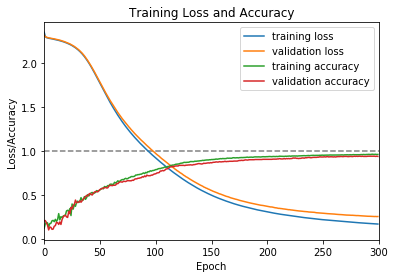

In [18]:
plt.figure()
plt.axhline(y=1., color='gray', linestyle='dashed')
plt.plot(H.history["loss"][:300], label="training loss")
plt.plot(H.history["val_loss"][:300], label="validation loss")
plt.plot(H.history["accuracy"][:300], label="training accuracy")
plt.plot(H.history["val_accuracy"][:300], label="validation accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.xlim(0, 300)
plt.legend()
plt.savefig('Keras_mnist.pdf')
plt.show()

### Using ReLU layers

In practice, you should always try ReLU over Sigmoid as it as proven to provide a better learning ability to the network (help with vanishing gradients).

In [ ]:
model_relu = Sequential()
model_relu.add(Dense(32, input_shape=(64, ), activation='relu'))
model_relu.add(Dense(16, activation='relu'))
model_relu.add(Dense(10, activation='softmax'))

In [ ]:
model_relu.summary()

In [ ]:
sgd = SGD(0.01)
model_relu.compile(
    loss='categorical_crossentropy', 
    optimizer=sgd, 
    metrics=['accuracy'])

In [ ]:
X_train.shape

In [ ]:
H = model_relu.fit(
    X_train, 
    y_train, 
    epochs=300, 
    validation_split=0.1, 
    verbose=1,
    shuffle=True,
    batch_size=16)

In [ ]:
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
ax2 = plt.subplot(1, 2, 2)
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
ax2.plot(epochs, acc, label='Training acc')
ax2.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.show()